In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

print(cv2.__version__)

4.9.0


/home/max/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


What a good detection system should handle?**

* **Scale invariance**: object in scene may appear at any scale, not only at the same resolution used for the model images.
* **Rotation invariance**: object may appear rotated or skewed in the scene.
* **Photometric invariance**: object may appear in any light condition.
* **Occlusion**: portion of the objects may not be visible in the scene.
* **Perspective distortion**: Object may appear fairly different if viewed from different camera viewpoint

### Local Invariant Features Paradigm

Allows to successfully identify objects in scene from a
single model image per object.

**Pros:**
* Quite effective for the detection of textured objects.
* Scale/rotation and illumination invariant.
* Works under partial occlusion.
* Only one model image per object required.
* Fully implementable in openCV with few lines of code.

**Cons**:
* Suffers from changes in camera viewpoint.
* Can be slow when the number of objects to recognize increases
* Does not work well with deformable objects or to detect categories of objects.

**Four steps**:
1. **Detection**: Identify salient repeatable points (Keypoints) in model and scene images.
2. **Description**: Create a unique description of each point, usually based on its local pixel neighborhood.
3. **Matching**: Match point from scene and model according to a similarity function between the descriptors.
4. **Position Estimation**: Estimate the position of the object in the scene image given enough matching points

[ WARN:0@7.690] global loadsave.cpp:248 findDecoder imread_('wild-boar.webp.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

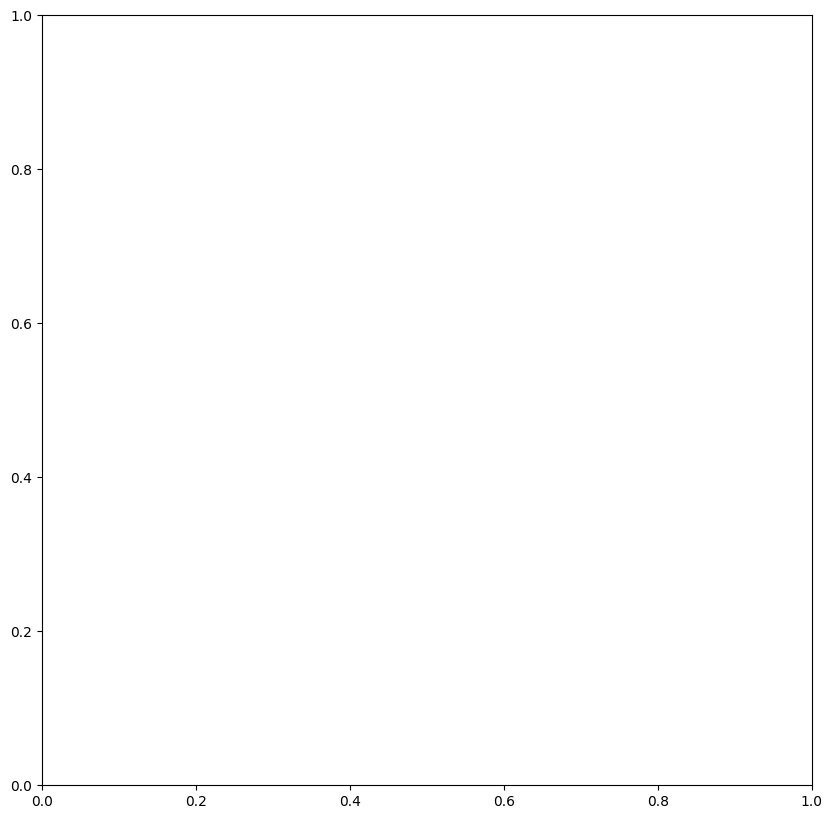

In [3]:
img_target = cv2.imread('wild-boar.webp.png', cv2.IMREAD_GRAYSCALE) # trainImage
plt.figure(figsize=(20,10))
plt.imshow(img_target, cmap='gray', vmin=0,vmax=255)
plt.show()

In [ ]:
img_ref = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_ref, cmap='gray',vmin=0,vmax=255)
plt.show()

### 1. Keypoint Detection

Common schema:

1. Compute a saliency score for each pixel location based on the response to different mathematical operators.
2. Keep only the points that are local extrema.
3. For each keypoint estimate the ‘scale’ at which it is salient (scale invariance) and the orientation (rotation invariance).

In [4]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_ref = sift.detect(img_ref)
print(kp_ref)

AttributeError: module 'cv2' has no attribute 'xfeatures2d'

In [ ]:
# https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_feature_detectors.html#Point2f%20pt

# Number of keypoints
print(len(kp_ref))

# Location of the keypoint
print(kp_ref[0].pt)

# Scale
print(kp_ref[0].size)

# Rotation
print(kp_ref[0].angle)

In [ ]:
# Visualize keypoints with drawKeypoints
# Use flag DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to show scale and orientation
# "None" is for specifying an output image
img_visualization = cv2.drawKeypoints(img_ref, kp_ref, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img_visualization)
plt.show()

In [ ]:
# Let us find and draw the keypoints for the target image:
kp_target = sift.detect(img_target)

img = cv2.drawKeypoints(img_target,kp_target,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

### 2. Keypoints Description

Compute for each keypoint a unique description usually based on the nearby pixels.

A good keypoint descriptor should be:
* Repeatable: the descriptions computed at homologus points should be as similar as possible.
* Distinctive: capture the salient informations around the keypoint despite various nuisances (e.g. light changes).
* Compact: minimize memory occupancy to allow efficient matching.
* Fast: it is usually applied to hundred or thousand of keypoints in each image.

Different algorithms provides different descriptions, the common idea is to describe keypoints using an array (histogram) of values that encodes the appearance of its local neighborhood. The size of the support depends on the scale associated to the keypoint (i.e. scale invariance).

The histogram used for the description could be made of:
* floats: more distinctive, high memory footprint
* bits: less distinctive, small memory footprint (binary descriptors)


In [ ]:
# Describing keypoints for query and train images
kp_ref, des_ref = sift.compute(img_ref, kp_ref)
kp_target, des_target = sift.compute(img_target, kp_target)

In [ ]:
print("Number of keypoints: ", len(kp_ref))
print("Number of keypoints target: ", len(kp_target))
print("Number of ref descriptors: ", len(des_ref))
print("Dimensionality of a SIFT descriptor: ", des_ref[0].shape)
print("Type of the descriptor: ", des_ref[0].dtype)

Number of keypoints:  604
Number of keypoints target:  969
Number of ref descriptors:  604
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


### 3. Feature Matching

Descriptors extracted from the scene are compared with those extracted from the models to find couples of similar ones. Classic Nearest Neighbour(NN) search problem.

In our scenario points are feature vectors and the distance function is Euclidean distance for floats or Hamming distance for bits.

Brute force matching is too slow => use efficient indexing such as KD-tree techniques borrowed from database management to speed up the search:
* Kd-tree - exact
* Locality-sensitive hashing (LSH) - for binary descriptor

For instance, we will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV.

**FLANN** contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

In [ ]:
# FLANN_INDEX_LINEAR = 0
# Scale
print(kp_ref[0].size)

# Rotation
print(kp_ref[0].angle)
# FLANN_INDEX_KDTREE = 1
# FLANN_INDEX_KMEANS = 2
# FLANN_INDEX_COMPOSITE = 3
# FLANN_INDEX_KDTREE_SINGLE = 4
# FLANN_INDEX_HIERARCHICAL = 5
# FLANN_INDEX_LSH = 6
# FLANN_INDEX_SAVED = 254
# FLANN_INDEX_AUTOTUNED = 255
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params) # flann is used for the matching.

# Matching and finding the 2 closest elements for each query descriptor.
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
matches = flann.knnMatch(des_ref,des_target,k=2)
print(matches[0])

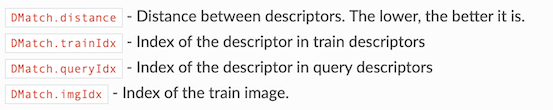

### Filtering False Matches in SIFT
To **filter** the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches.

The **distance ratio** between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a threshold.

Indeed, this ratio allows helping to discriminate between **ambiguous matches** (distance ratio between the two nearest neighbors is close to one).

We iterate along all matches checking the distance ratio between the first and the second closest elements using 0.7 as distance ratio threshold:

In [ ]:
good_matches = []
trs = 0.7
for m,n in matches:
    if m.distance < trs*n.distance:
        good_matches.append(m)
print(len(good_matches))

73


### 4. Position Estimation

To find the position we have to compute, given the **correspondences**, a suitable transformation that brings points from the model reference system to the scene one.

**Homography**: transformation that relates any two images of the same planar surface under the pinhole camera model.
Given corresponding pairs of points (m,s) estimate an homography

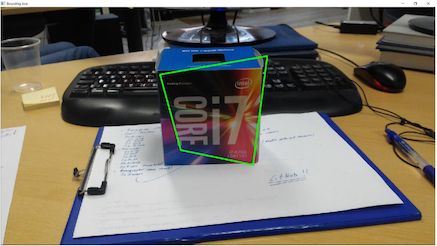

**PROBLEM: some of the match are completely wrong and the estimated homography can be quite bad...**

We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

### RANSAC algorithm:
Given a set of observation $O=\{o_1...o_n\}$ and a certain parametric model $M$, repeat iteratively:
1. Pick a random (small) subset $I$ of $O$ called inlier set (for homography at least 4).
2. Fit a model $M_i$ according to the observations in $I$.
3. Test all the other observations against $M_i$, add to a new set $C$ (consensus set) all the observations that fit $M_i$ according to a model specific loss function (reprojection error).
4. If the consensus set is bigger than the one associated with the current best model $M_b$, proceed to step 5, other way return to step 1.
5. Re-compute $M_i$ according to the observations in $I \cup C$, then set $M_b=M_i$. Restart from step 1.

The procedure is repeated for a fixed amount of steps, at the end the best model is returned.

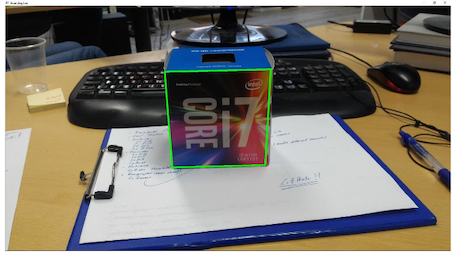

Given the set of good matches found before we can perform the following step to find the position of the query object in the train image:
* We set a condition that at least N matches (defined by MIN_MATCH_COUNT) have to be there to find the object
* If enough matches are found, we extract the locations of matched keypoints in both the images building correspondences arrays.
* We use the correspondences to estimate an homography
* Once we get the 3x3 transformation matrix, we use it to transform the corners of the query image to corresponding points in the train image

In [ ]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good_matches)>MIN_MATCH_COUNT:
    # building the correspondences arrays of good matches
    src_pts = [ kp_ref[m.queryIdx].pt for m in good_matches ]
    src_pts = np.float32(src_pts)
    dst_pts = [ kp_target[m.trainIdx].pt for m in good_matches ]
    dst_pts = np.float32(dst_pts)
    print("Query points length", src_pts.shape)
    print("Refeerence points length", dst_pts.shape)

    # Using RANSAC to estimate a robust homography.
    # https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
    print("Homography", M)

    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    print("Mask", matchesMask)

    # Corners of the query image
    print(img_ref.shape)
    h, w = img_ref.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])

    # Projecting the corners into the train image
    contour = cv2.perspectiveTransform(np.array([pts]),M)

else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = None

print(len(good_matches))

In [ ]:
# Drawing the bounding box
img_train = cv2.polylines(img_target,[np.int32(contour)],True,(255,255,255),3, cv2.LINE_AA)

# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img_matches = cv2.drawMatches(img_ref,kp_ref,img_target,kp_target,good_matches,None,**draw_params)
plt.imshow(img_matches, 'gray')
plt.show()

75

Query points length (75, 2)
Refeerence points length (75, 2)
Homography [[-2.02164907e+00  2.64755988e-01  7.06809414e+01]
 [-1.12607144e+01  1.15541870e+00  3.02431750e+02]
 [-3.23768998e-02  2.86793125e-03  1.00000000e+00]]
Mask [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(500, 370)


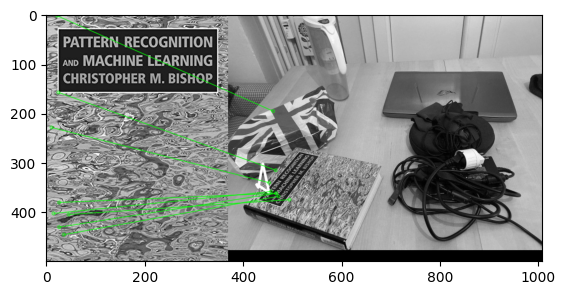

75

Query points length (75, 2)
Refeerence points length (75, 2)
Homography [[-1.65993482e+00  5.80747293e-02  7.98963284e+01]
 [-7.10372312e+00  5.43328210e-02  3.45838214e+02]
 [-2.11345305e-02  5.93386813e-04  1.00000000e+00]]
Mask [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(500, 370)


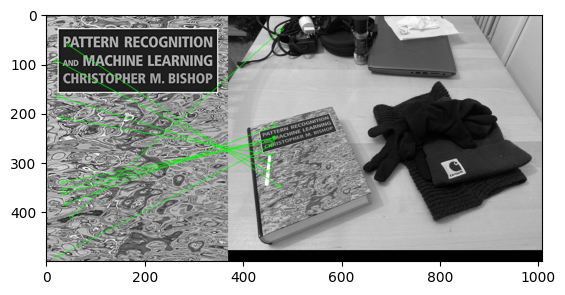

In [ ]:
# Image Search: given a reference image and several target images implement an
# algorithm to find which images contain the reference object

# Define a function for object detection pipeline
def pipeline(images):
  # Initiate SIFT detector
  sift = cv2.xfeatures2d.SIFT_create()

  # find the keypoints and descriptors with SIFT
  img_ref = cv2.imread('bishop.jpg', cv2.IMREAD_GRAYSCALE)
  img = cv2.imread('scene1.jpg', cv2.IMREAD_GRAYSCALE)

  for image in images:
    img_target = cv2.imread(image, cv2.IMREAD_GRAYSCALE) # Reading the image

    kp_ref = sift.detect(img_ref) # Making the detection for reference image with sift
    kp_target = sift.detect(img_target) # Making the detection for target image with sift

    # Defining parameters for algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params) # flann is used for the matching.

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(des_ref,des_target,k=2)

    good_matches = []
    trs = 0.7
    for m,n in matches:
        if m.distance < trs*n.distance:
            good_matches.append(m)

    MIN_MATCH_COUNT = 10
    print(len(good_matches))
    print()
    if len(good_matches) > MIN_MATCH_COUNT:
        # building the correspondences arrays of good matches
        src_pts = [ kp_ref[m.queryIdx].pt for m in good_matches ]
        src_pts = np.float32(src_pts)
        dst_pts = [ kp_target[m.trainIdx].pt for m in good_matches ]
        dst_pts = np.float32(dst_pts)
        print("Query points length", src_pts.shape)
        print("Refeerence points length", dst_pts.shape)

        # Using RANSAC to estimate a robust homography.
        # https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        print("Homography", M)

        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()
        print("Mask", matchesMask)

        # Corners of the query image
        print(img_ref.shape)
        h, w = img_ref.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])

        # Projecting the corners into the train image
        contour = cv2.perspectiveTransform(np.array([pts]),M)

    else:
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
        matchesMask = None

    # Drawing the bounding box
    img_train = cv2.polylines(img_target,[np.int32(contour)],True,(255,255,255),3, cv2.LINE_AA)

    # Drawing the matches
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                      singlePointColor = None, # not draw keypoints only matching lines
                      matchesMask = matchesMask, # draw only inliers
                      flags = 2) # not draw keypoints only lines
    img_matches = cv2.drawMatches(img_ref,kp_ref,img_target,kp_target,good_matches,None,**draw_params)
    plt.imshow(img_matches, 'gray')
    plt.show()
# Iterate among all images and look for the reference object.
images = ['scene1.jpg', 'scene2.jpg']
pipeline(images)

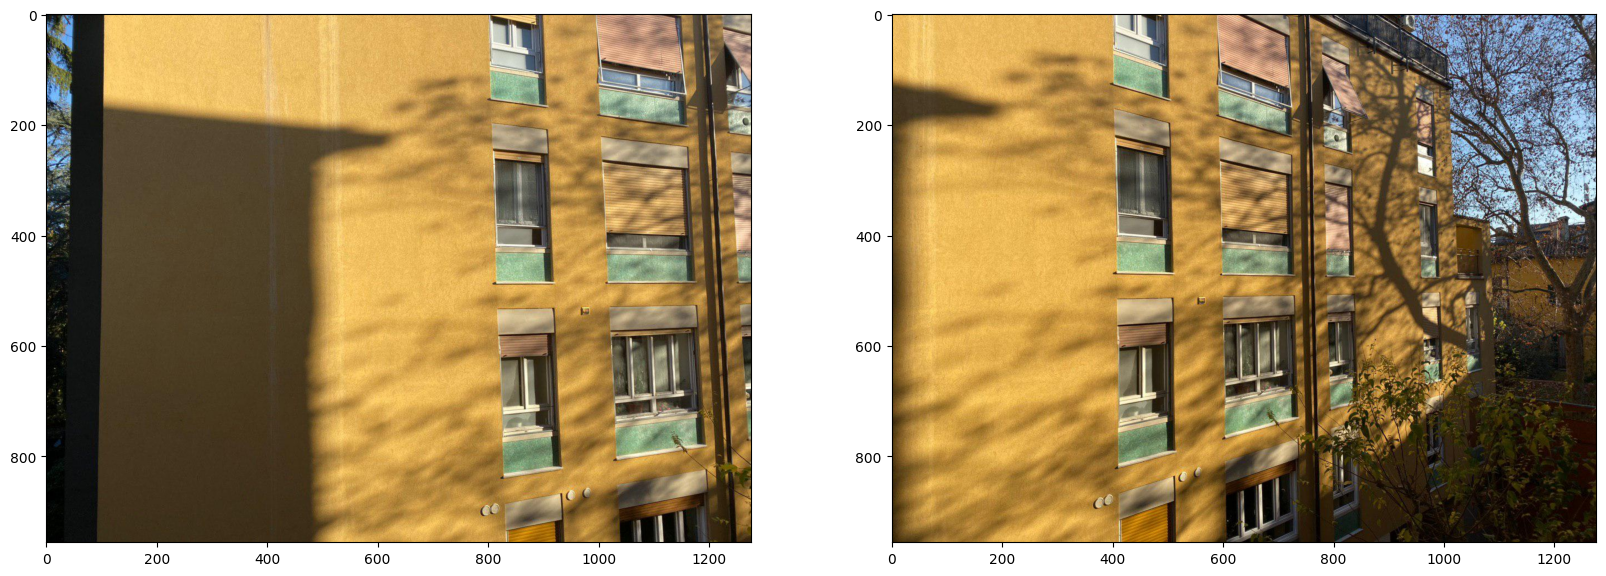

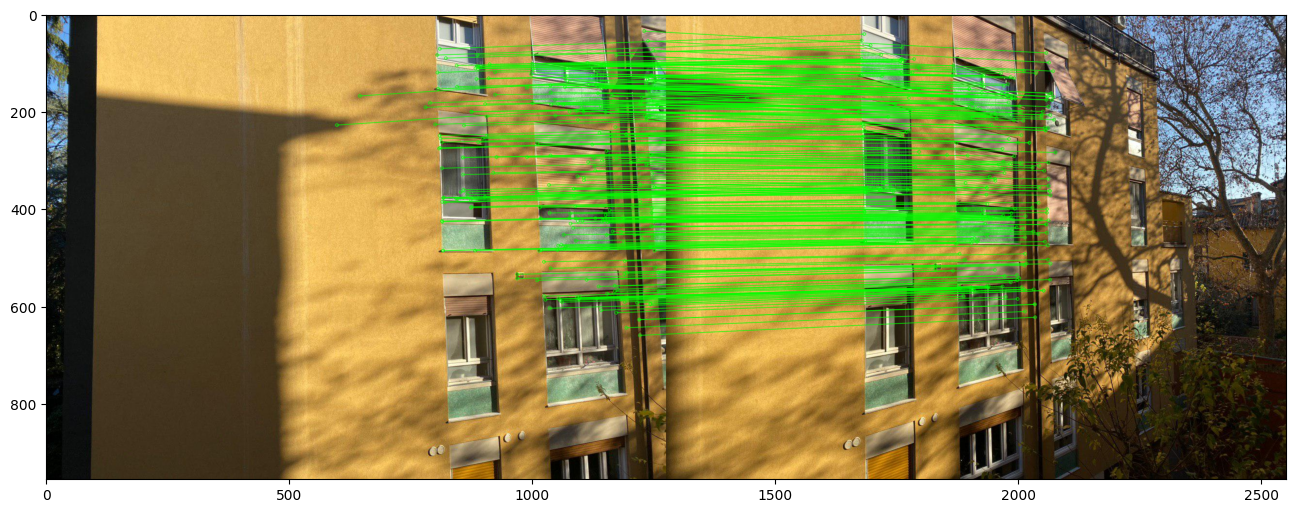

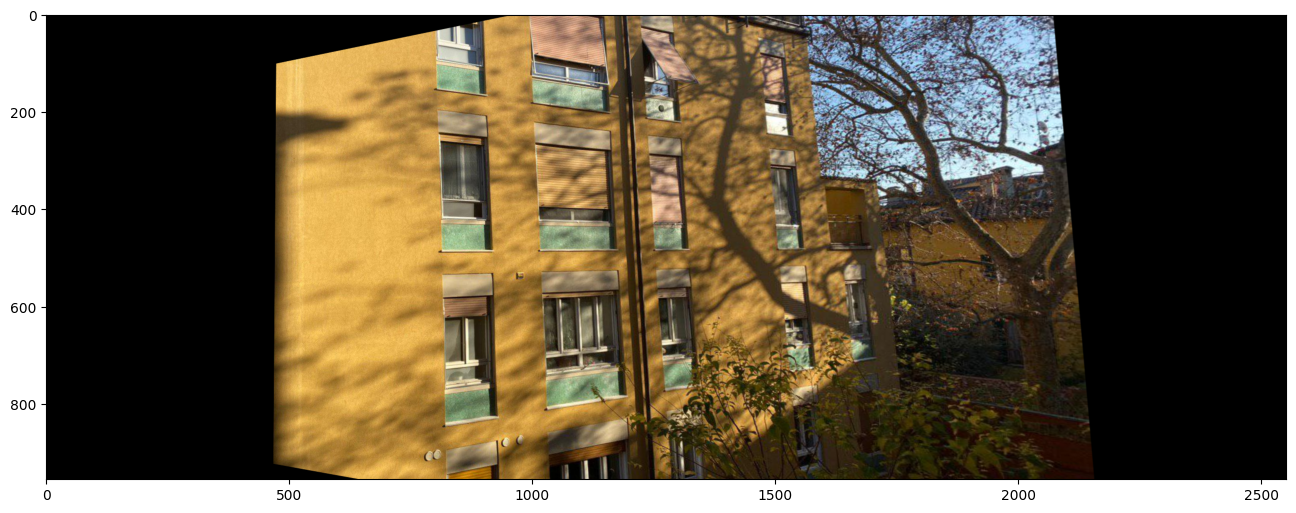

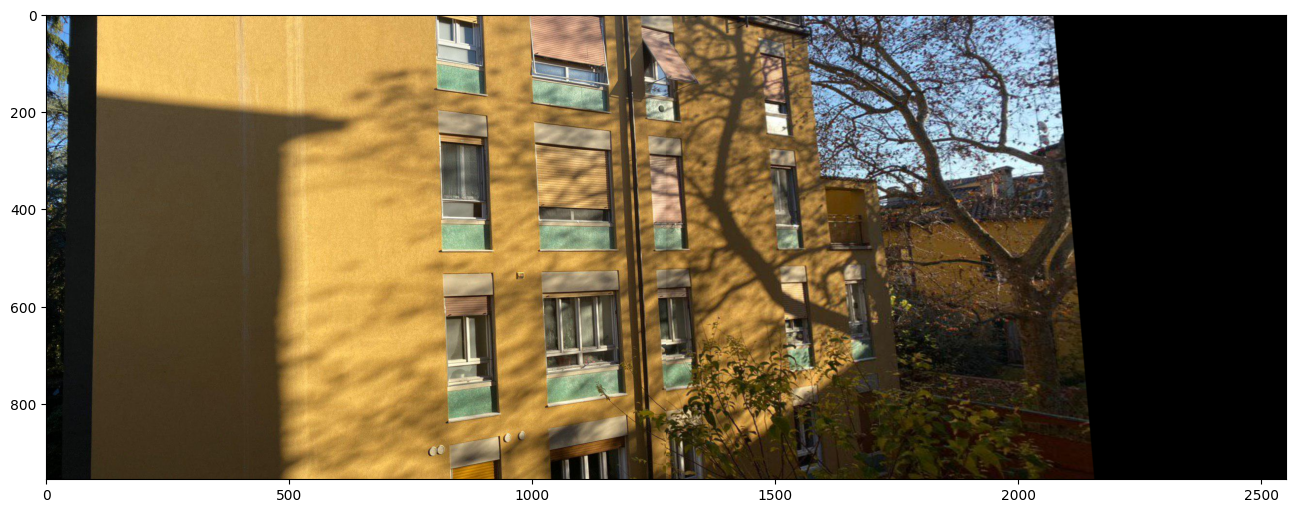

In [ ]:
# Mosaicing (aka Panorama Stitching): given two images stitch them in a single
# image
# * Find correspondences between the two images
# * Find an homography
# * Warp one image and restore values for the other image

# Loading images
img1 = cv2.imread('panorama_left_rgb.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.imread('panorama_right_rgb.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

# Getting correspondences
sift = cv2.xfeatures2d.SIFT_create()
kp1 = sift.detect(img1)
kp2 = sift.detect(img2)
kp1, des1 = sift.compute(img1, kp1)
kp2, des2 = sift.compute(img2, kp2)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# Finding an homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,2)
M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 1.0)
matchesMask = mask.ravel().tolist()

# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(16,8))
plt.imshow(img3)
plt.show()

# Warping right image with the homography. Result images having a bigger shape to contain both images.
result = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], img2.shape[0]))

# Displaying the result
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()

# Restoring left image values into the result image
result[0:img1.shape[0], 0:img1.shape[1]] = img1

# Displaying "again" the result
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()

Scene Image


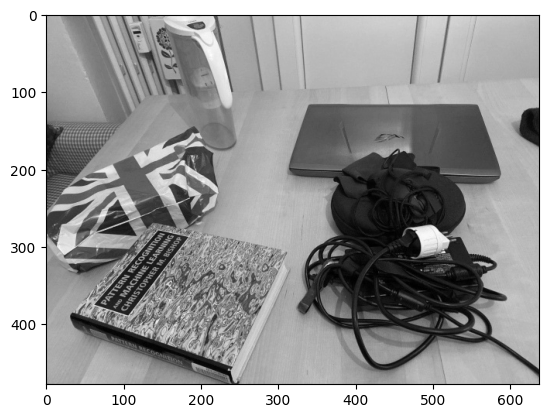

Query Image


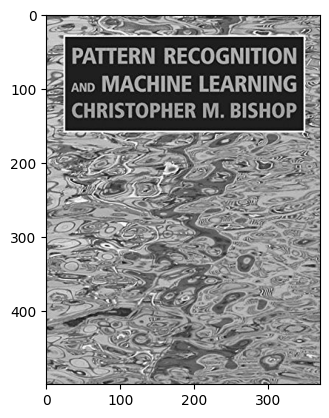

Image to Project


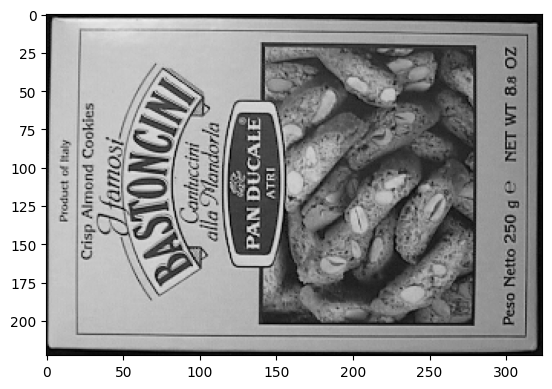

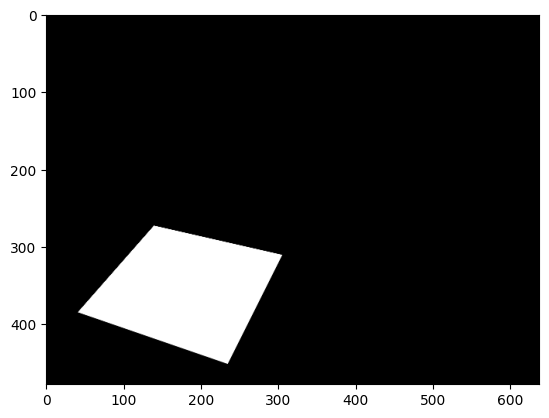

Result Image


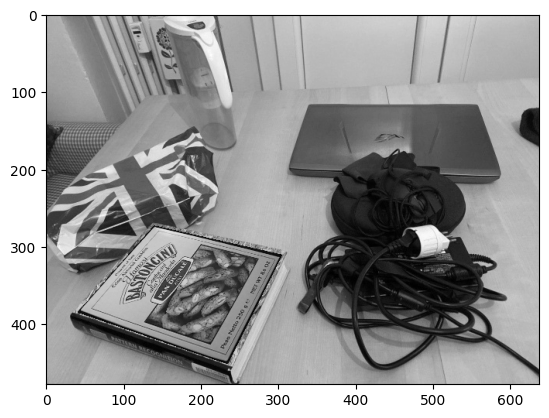

In [ ]:
# Augmentated Reality: Given an image implement an augmented reality algorithm
# to project the image into the surface of the query object.

# Loading images
img_train = cv2.imread('scene1.jpg', cv2.IMREAD_GRAYSCALE)
img_query = cv2.imread('bishop.jpg', cv2.IMREAD_GRAYSCALE)
img_ar = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)

print("Scene Image")
plt.imshow(img_train, 'gray', vmin=0, vmax=255)
plt.show()
print("Query Image")
plt.imshow(img_query, 'gray', vmin=0, vmax=255)
plt.show()
print("Image to Project")
plt.imshow(img_ar, 'gray', vmin=0, vmax=255)
plt.show()

# For a better visualization in this scene image.
# https://numpy.org/doc/stable/reference/generated/numpy.rot90.html
img_ar = np.rot90(img_ar, 3)

# Implementing the object detection pipeline
sift = cv2.xfeatures2d.SIFT_create()
kp_query = sift.detect(img_query)
kp_train = sift.detect(img_train)
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query,des_train,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# Checking if we found the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,2)

    # Getting the coordinates of the corners of our query object in the train image
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])
    dst = cv2.perspectiveTransform(np.array([pts]),M)

    h_t, w_t = img_train.shape
    h,w = img_ar.shape

    # Getting the homography to project img_ar on the surface of the query object.
    pts_ar = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,2)
    M = cv2.getPerspectiveTransform(pts_ar,dst)

    # Warping the img_ar
    warped = cv2.warpPerspective(img_ar, M, (w_t, h_t))

    # Warp a white mask
    white = np.ones([h,w],dtype=np.uint8)*255
    warp_mask = cv2.warpPerspective(white, M, (w_t, h_t))
    plt.imshow(warp_mask,'gray',vmin=0,vmax=255)
    plt.show()

    # Restore previous values of the train images where the mask is black
    warp_mask = np.equal(warp_mask, 0)
    warped[warp_mask] = img_train[warp_mask]

    # Displaying the result
    print("Result Image")
    plt.imshow(warped,'gray',vmin=0,vmax=255)
    plt.show()
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None